In [2]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
sns.set_style('darkgrid')
%matplotlib inline


//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [5]:
cur.execute('select name from sqlite_master where type ="table"').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [8]:
cur.execute("""SELECT *
               FROM 'OrderDetail' """)

df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]

df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
discount_rates = set(df.Discount.values)

In [11]:
avg_discount_order_size = {}

for d in discount_rates: 
    avg_discount_order_size[d] = df[df['Discount'] == d]['Quantity'].mean()
    
avg_discount_order_size

{0.0: 21.715261958997722,
 0.25: 28.24025974025974,
 0.2: 27.024844720496894,
 0.05: 28.01081081081081,
 0.15: 28.38216560509554,
 0.1: 25.23699421965318,
 0.03: 1.6666666666666667,
 0.06: 2.0,
 0.01: 2.0,
 0.04: 1.0,
 0.02: 2.0}

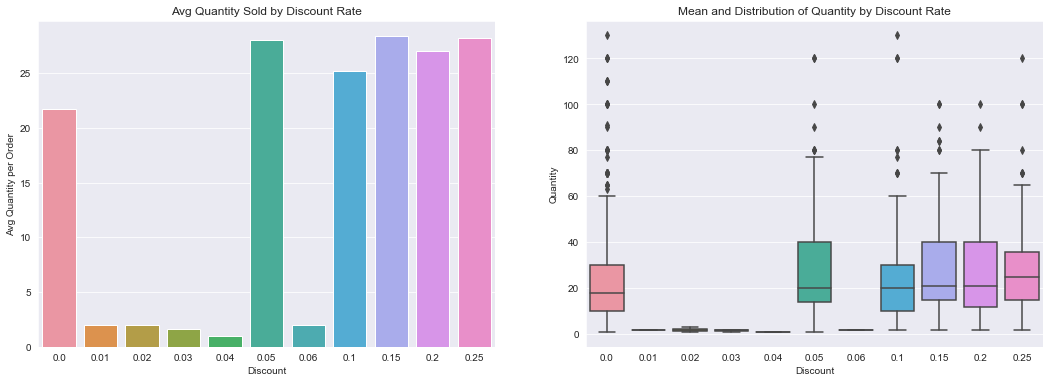

In [12]:
# set figure size and axes for two side-by-side plots
plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

# plot the average quantity sold at each level of discount
a = sns.barplot(x=list(avg_discount_order_size.keys()), y=list(avg_discount_order_size.values()), ax=ax1)
a.axes.set_title('Avg Quantity Sold by Discount Rate')
a.axes.set_xlabel('Discount')
a.axes.set_ylabel('Avg Quantity per Order')

# plot the mean and distribution of quantity sold at each discount level
b = sns.boxplot(x=df.Discount, y=df.Quantity, data=df, ax=ax2)
b.axes.set_title('Mean and Distribution of Quantity by Discount Rate')

plt.show()

In [13]:
no_d = np.array(df[df['Discount'] == 0.0]['Quantity'])
d = np.array(df[df['Discount'] != 0.0]['Quantity'])

In [86]:
d

array([ 35,  15,   6,  15,  40,  25,  15,  21,  50,  65,   6,  16,  15,
        21,  12,  60,  60,  36,  25,  12,  70,  15,  60,  20,  24,  15,
        60,  33,  12,   6,  15,  15,  20,   5,  45,  40,  36,  40,  15,
        10,   3,  20,  24,   2,  40,  30,  40,  30,  15,  25,  25,  30,
        40,  30,  25,  21,  70,  40,  80,  25,  50,  35,  30,  10,   8,
        20,  12,  50,  25,  40,  10,  16,  10,  40,   7,  25,   6,  48,
        18,  70,  20,  12,  40,   9,  24,  56,  40,  40,   4,  70,  36,
        50,   6,  15,  15,  18,  20,  77,  10,  20,  12,  50,  30,   8,
        10,  10,  20,  56,  70,  80,  54,  55,   5,  13,  35,  18,  15,
        20,   6,  12,  40,  70,  42,  80,  50,  42,  20,  20,   8,  16,
        20,  18,  20,   6,  10,  20,   8,  15,  20,  60,  40,  24,  25,
        42,   7,  70,  28,  70,  10,  18, 120,  21,  70,  30,  40,  30,
        30,  42,   5,   2,  25,  40,   9,  20,  18,   2,  36,  60,  20,
        20,   2,   8,  20,   4,  15,  10,  60,  49,  30,  10,  2

In [24]:
print("Size of no discount group: ", len(no_d))
print("Size of discount group: ", len(d))
print("Mean quantity of no discount group: ", round(no_d.mean(), 2))
print("Mean quantity of discount group: ", round(d.mean(), 2))
print("Standard deviation of no discount group: ", round(no_d.std(), 2))
print("Standard deviation of discount group: ", round(d.std(), 2))

Size of no discount group:  1317
Size of discount group:  838
Mean quantity of no discount group:  21.72
Mean quantity of discount group:  27.11
Standard deviation of no discount group:  17.5
Standard deviation of discount group:  20.76


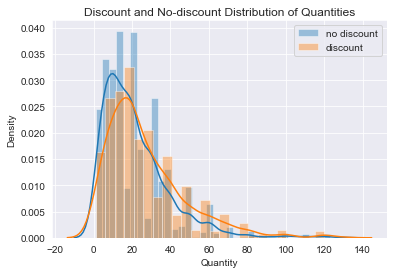

In [25]:
# plot two distribution plots together to compare
sns.distplot(no_d, label='no discount')
sns.distplot(d, label='discount')
plt.legend()
plt.title('Discount and No-discount Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Density');

**Null Hypothesis (H0): There is no relationship between discount and quantity ordered**

**Alternative Hypothesis (Ha): There is a positive relationship between discount and quantity ordered - a discount is likely to result in a larger order**

In [26]:
alpha=.05

In [27]:
stats.shapiro(no_d)

(0.8434571027755737, 3.803856556577728e-34)

In [28]:
stats.shapiro(d)

(0.8690301179885864, 6.88120409395894e-26)

In [69]:
def get_sample(data):
    import numpy as np
    sample = np.random.choice(data,30)
    return sample

In [70]:
def get_sample_mean(data):
    sample_means = []
    for i in range(30):
        sample_means.append(get_sample(data).mean())
    return sample_means

In [71]:
no_discount_sample = get_sample_mean(no_d)

In [72]:
stats.shapiro(no_discount_sample)

(0.9558246731758118, 0.24140672385692596)

In [73]:
discount_sample = get_sample_mean(discount)

In [74]:
stats.shapiro(discount_sample)

(0.9624248147010803, 0.35674092173576355)

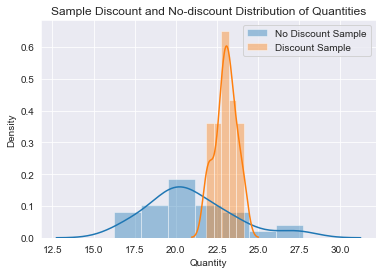

In [75]:
sns.distplot(no_discount_sample, label='No Discount Sample')
sns.distplot(discount_sample, label='Discount Sample')
plt.legend()
plt.title('Sample Discount and No-discount Distribution of Quantities')
plt.xlabel('Quantity')
plt.ylabel('Density');

In [76]:
stats.levene(no_discount_sample, discount_sample)

LeveneResult(statistic=17.58009006046259, pvalue=9.535029533948922e-05)

In [87]:
# run a independent t-test with unequal varance to determine p
p = stats.ttest_ind(no_discount_sample, discount_sample, axis=0, equal_var=False)[1]

In [79]:
p

0.00014416611813477097

In [81]:
def cohens_d(sample1,sample2):
    from numpy import std, mean, sqrt
    n1 = len(sample1)
    n2 = len(sample2)
    deg_freed = n1 + n2 - 2
    return abs(mean(sample1) - mean(sample2)) / sqrt(((n1 - 1) * std(sample1, ddof=1) **2 + (n2 - 1) * std(sample2, ddof=1) **2) / deg_freed)

In [88]:
discount_effect = cohens_d(no_discount_sample, discount_sample)
discount_effect

1.1114005567429248

In [85]:
power = TTestIndPower()
power.solve_power(effect_size=discount_effect, nobs1=len(discount_sample), alpha=alpha, alternative='larger')

0.9954549483628078

In [90]:
power.solve_power(effect_size=discount_effect, power = 0.8, alpha=alpha, alternative='larger')

10.7565124607786